## Demand Forecasting with LightGBM, SES, DES, TES, ARIMA and SARIMA

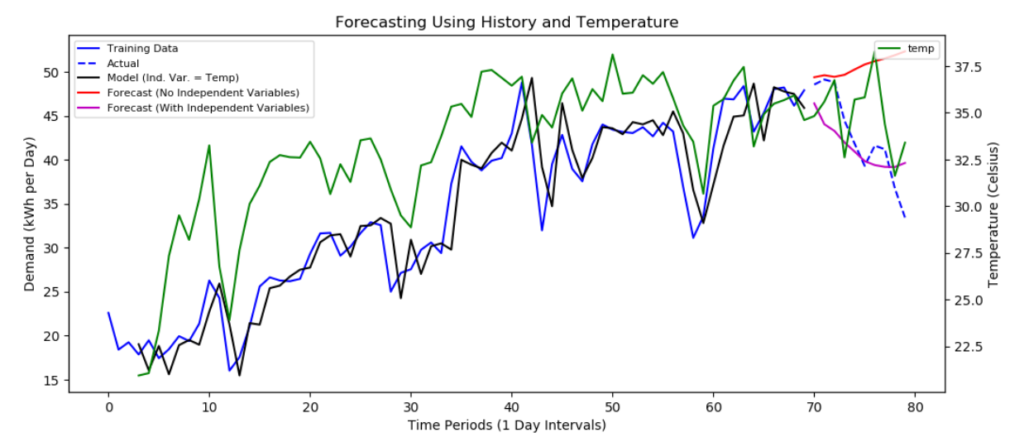

## Content
1. [Introduction](#section-intro)
2. [Load Dataset and EDA](#section-ts)
3. [Feature Engineering](#section-pro)
    * [Random Noise](#section-one)
    * [Lag/Shifted Features ](#section-two)
    * [Rolling Mean Features ](#section-three)    
    * [Exponentially Weighted Mean Features ](#section-four)
4. [MODEL](#section-ten)
    * [One-Hot Encoding](#section-eleven)
    * [Converting sales to log(1+sales)](#section-eleven)
    * [LightGBM Model](#section-twelve) 
    * [Custom Cost Function](#section-thirteen)
    * [Final Model](#section-fourteen)
    * [1.Mağazanın 1. Ürünü için Yapılan Tahminler](#section-fifteen)
    * [1.Mağazanın 17. Ürünü için Tahmin Edilen Değerler](#section-fifteen)
5. [TIME SERIES PART](#section-ten)
    * [Load Dataset and EDA](#section-eleven)
    * [Feature Engineering](#section-eleven)
    * [LightGBM Model](#section-eleven)
    * [Feature Importance](#section-eleven)
    * [Time Series Analysis](#section-eleven)
    * [Single Exponential Smoothing ](#section-eleven)
    * [Double Exponential Smoothing](#section-eleven)
    * [Triple Exponential Smoothing ](#section-eleven)
    * [ARIMA](#section-eleven)
    * [SARIMA](#section-eleven)
    

## 1. Introduction

#### Veri Setine Genel Bakış
* Bir mağaza zincirinin 5 yıllık verilerinde, 10 farklı mağaza ve 50 farklı ürünün bilgileri yer almaktadır.
* Veri seti 01-01-2013 ile 31-12-2017 arasındaki dönemi kapsamaktadır.

#### İş Problemi
* Bir mağaza zincirinin 10 farklı mağazası ve 50 farklı ürünü için 3 aylık bir talep tahmini modeli oluşturulmak istenmektedir.
* Daha sonra ise veri seti haftalığa indirgenip 2017 yılı için bir talep tahmin modeli oluşturulmak istenmektedir.

#### Değişkenler
* date – Satış verilerinin tarihi Tatil efekti veya mağaza kapanışı yoktur.
* store – Mağaza ID’si Her bir mağaza için eşsiz numara.
* item – Ürün ID’si Her bir ürün için eşsiz numara.
* sales – Satılan ürün sayıları, Belirli bir tarihte belirli bir mağazadan satılan ürünlerin sayısı

In [ ]:
# Gerkli Kütüphaneler ve Ayarlar

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



## 2. Load Dataset and EDA

In [ ]:
train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False) # veri önişleme için test ve train bir araya getirdim
df.head()

In [ ]:
print("Train setinin boyutu:",train.shape)
print("Test setinin boyutu:",test.shape)

In [ ]:
df.shape

In [ ]:
df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T # Aykırılık gözükmüyor.

In [ ]:
df["date"].min()

In [ ]:
df["date"].max()

In [ ]:
# Satış dağılımı nasıl?
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

In [ ]:
# Kaç store var?
df["store"].nunique()

In [ ]:
# Kaç ürün var?
df["item"].nunique() 

In [ ]:
# Her store'da eşit sayıda mı eşsiz ürün var?
df.groupby(["store"])["item"].nunique()

In [ ]:
# Mağaza-ürün kırılımında satış istatistikleri
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

## 3. Feature Engineering

In [ ]:
# hangi ayda satış yapılmış
df['month'] = df.date.dt.month
# ayın hangi gününde satış yapılmış
df['day_of_month'] = df.date.dt.day
# yılın hangi gününde satış yapılmış
df['day_of_year'] = df.date.dt.dayofyear 
# yılın hangi haftasında satış yapılmış
df['week_of_year'] = df.date.dt.weekofyear
# haftanın hangi gününde satış yapılmış
df['day_of_week'] = df.date.dt.dayofweek
# hangi yılda satış yapılmış
df['year'] = df.date.dt.year
# haftasonu mu değil mi
df["is_wknd"] = df.date.dt.weekday // 4
# ayın başlangıcı mı
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
# ayın bitişi mi
df['is_month_end'] = df.date.dt.is_month_end.astype(int) 

In [ ]:
df.head()

In [ ]:
# store-item-month kırılımında satış istatistikleri
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

### Random Noise

In [ ]:
# Bu veri seti gibi küçük veri kümeleri için, overfittingi önlemek amacıyla değerlere rastgele gürültü eklenebilir.
# Ben burada normal olarak 1 standart sapma ve 0 ortalama ile dağılan Gauss rastgele gürültüsünü ekleyeceğim.

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

### Lag/Shifted Features (Gecikmeler)

In [ ]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df.head(10)

In [ ]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

### Rolling Mean Features (Hareketli Ortalamalar)

In [ ]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546, 730])


### Exponentially Weighted Mean Features (Üssel Ağırlıklı Ortalama Featureları)

In [ ]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

In [ ]:
df.tail()

## 4. MODEL (3 Aylık Talep Tahmini için)

### One-Hot Encoding

In [ ]:
# Değişken türetme işlerim bitti şimdi ML hazırlıklarına başlıyorum.
df = pd.get_dummies(df, columns=['day_of_week', 'month'])

### Converting sales to log(1+sales)

In [ ]:
df['sales'] = np.log1p(df["sales"].values)

### LightGBM Model

In [ ]:
# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

# 2017'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

# bağımsız değişkenler
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [ ]:
# train seti için bağımlı değişkenin seçilmesi
Y_train = train['sales']

# train seti için bağımsız değişkenin seçilmesi
X_train = train[cols]

# validasyon seti için bağımlı değişkenin seçilmesi
Y_val = val['sales']

# validasyon seti için bağımsız değişkenin seçilmesi
X_val = val[cols] 

# kontrol
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

In [ ]:
# Custom Cost Function

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False


In [ ]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, # hatyı gözlemliyoruz
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

# validasyon hatasının yüzdesi
smape(np.expm1(y_pred_val), np.expm1(Y_val))

### Final Model

In [ ]:
# test ve train bağımlı/bağımsız değişkenlerinin belirlenmesi

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [ ]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

### 1. mağazanın 1.ürünleri için yapılan tahminler

In [ ]:
forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Store 1 Item 1 Forecast");


### 1.Mağazanın 17. Ürünü İçin Tahmin Edilen Değerler

In [ ]:
train[(train.store == 1) & (train.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 17 Forecast");

## 5. TIME SERIES PART

* Bu bölümde öncelikle train veri seti haftalığa indirgenecektir.
* Daha sonra haftalığa indirgenmiş veri seti kullanılarak sırasıyla :
* LightGBM Model 
* Single Exponential Smoothing
* Double Exponential Smoothing
* Triple Exponential Smoothing
* ARIMA
* SARIMA ile 2017 yılına ait satış talep tahmin modelleri oluşturulacaktır.
* Gerçek değerler ile tahmin edilen değerler karşılaştırılacaktır.


### Load Dataset and EDA

In [ ]:
data = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
data.head()
data.shape

# veri setini haftalığa indirgeme
data.set_index("date",inplace=True)
df= data.resample("W").mean()
df.reset_index(inplace=True)
df.head()
df.shape

df.index.freq = "W"
df.head()

In [ ]:
df.shape

### Feature Engineering

In [ ]:
# hangi ayda satış yapılmış
df['month'] = df.date.dt.month
# ayın hangi gününde satış yapılmış
df['day_of_month'] = df.date.dt.day
# yılın hangi gününde satış yapılmış
df['day_of_year'] = df.date.dt.dayofyear
# yılın hangi haftasında satış yapılmış
df['week_of_year'] = df.date.dt.weekofyear
# haftanın hangi gününde satış yapılmış
df['day_of_week'] = df.date.dt.dayofweek
# hangi yılda satış yapılmış
df['year'] = df.date.dt.year
# haftasonu mu değil mi
df["is_wknd"] = df.date.dt.weekday // 4
# ayın başlangıcı mı
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
# ayın bitişi mi
df['is_month_end'] = df.date.dt.is_month_end.astype(int)

# Lag/Shifted Features (Gecikmeler)
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [31, 61, 91, 98, 105, 112])


# Rolling Mean Features (Hareketli Ortalamalar)
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [31, 61, 91, 98, 105, 112])


# Exponentially Weighted Mean Features (Üssel Ağırlıklı Ortalama Featurs
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [10, 20, 30, 40, 50]

df = ewm_features(df, alphas, lags)

df.tail()


### LightGBM Model

In [ ]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['day_of_week', 'month'])

# Converting sales to log(1+sales)
df['sales'] = np.log1p(df["sales"].values)

# train-test seti
train = df.loc[(df["date"] < "2017-01-01"), :]
test = df.loc[(df["date"] >= "2017-01-01"), :]

# bağımlı ve bağımsız değişkenler
cols = [col for col in train.columns if col not in ['date', "sales", "year"]]
X_train = train[cols]
Y_train = train['sales']
X_test = test[cols]
Y_test = test["sales"]


In [ ]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200, 
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_test, label=Y_test, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, 
                  verbose_eval=100)

y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

# test hatasının yüzdesi
smape(np.expm1(y_pred_test), np.expm1(Y_test))


### Feature Importance

In [ ]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


plot_lgb_importances(model, num=30)
plot_lgb_importances(model, num=30, plot=True)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()


In [ ]:
# Final Model

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)


In [ ]:
# 1 yıllık gerçek ve tahmin edilen değerler
forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

df.set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Actual")
forecast.set_index("date").sales.plot(legend=True, label = "Predict")
plt.show()

### Time Series Analysis

In [ ]:
df.index.freq = "W"
dff = pd.DataFrame({"date":df["date"], "sales":df["sales"]})
dff.index = dff["date"]
dff.drop("date",axis=1, inplace=True)
dff.head()

# Durağanlık Testi (Dickey-Fuller Testi)
def is_stationary(y):

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

# Zaman Serisi Bileşenleri ve Durağanlık Testi
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

ts_decompose(dff, model="additive")

### Single Exponential Smoothing (SES)

In [ ]:
train_dff = dff.loc[(dff.index < "2017-01-01"), :]
test_dff = dff.loc[(dff.index >= "2017-01-01"), :]

dff.index.freq = "W"

def ses_optimizer(train, alphas, step=48):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test_dff, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(train_dff, alphas, step=53)

ses_model = SimpleExpSmoothing(train_dff).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(53)

def plot_prediction(y_pred, label):
    train_dff["sales"].plot(legend=True, label="TRAIN")
    test_dff["sales"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

plot_prediction(y_pred, "Single Exponential Smoothing")


### Double Exponential Smoothing

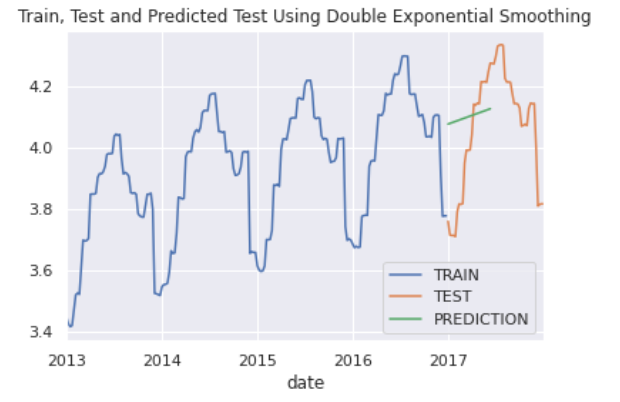

### Triple Exponential Smoothing 

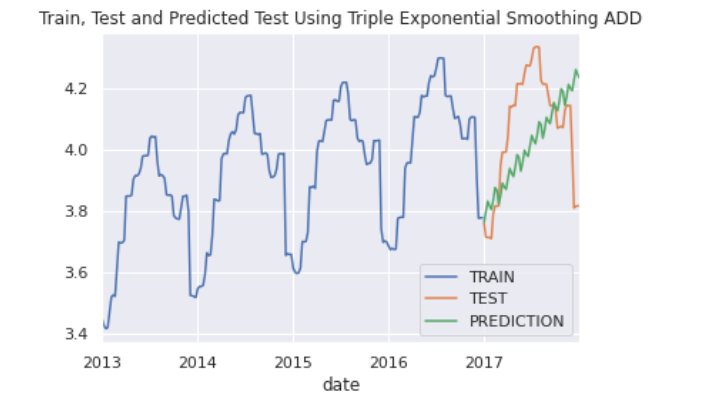

### ARIMA

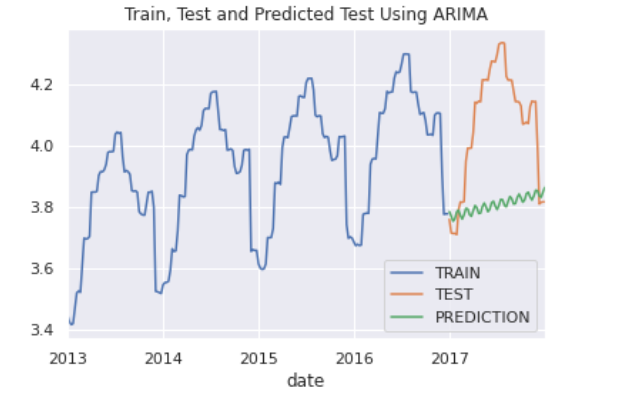

### SARIMA

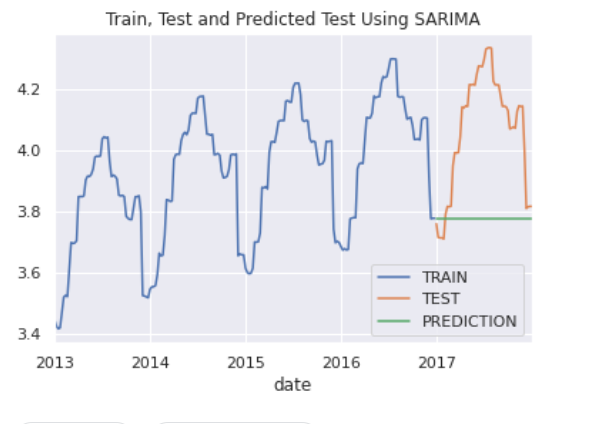